# Machine Learning Fundamentals - Probability Theory - Bayesian Networks by Example

## Table of Contents

* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)


* [Student Example](#Student-Example)
  * [Example: Common Cause](#Example:-Common-Cause)
  * [Example: Indirect Causal Effect](#Example:-Indirect-Causal-Effect)
  * [Example: Common Effect](#Example:-Common-Effect)
* [Theory](#Theory)
  * [Observed Variables](#Observed-Variables)
  * [Trails](#Trails)
* [Inference](#Inference)
  * [Inference: Indirect Causal Effect](#Inference:-Indirect-Causal-Effect)
  * [Inference: Indirect Evidential Effect](#Inference:-Indirect-Evidential-Effect)
  * [Inference: Common Cause](#Inference:-Common-Cause)
  * [Inference: Common Effect](#Inference:-Common-Effect)


* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

Bayesian Networks are probabilistic models which describe interactions between random variables as a directed acyclic graph (DAG). A Bayesian Network can only be an approximation of the real world it tries to model. On the other hand, the model can encode useful assumptions about the problem domain, which enables us to reason about the problem and to reduce the computational complexity.

This notebooks uses probability distributions of the "student" example [[KOL09](#KOL09)] as a minimal introduction to Bayesian Networks and how to represent them in a graphical way. Bayesian Networks are themselves the foundation of sequence learning algorithms like Markov Models and Hidden Markov Models, which can be used in Natural Language Processing (NLP) like Language Models or [Tagging Problems](../../../text-information-extraction.md) respectively.

In this notebook we use the Python package `networkx` as a generic way of representing a DAG and `pandas` to store probability tables assigned to graph nodes.

## Requirements

### Knowledge

The following Jupyter notebooks are preliminary material:

* [Bayes' Theorem](bayes-theorem.ipynb)
* [Exercise: Cookie Problem](exercise-cookie-problem.ipynb)

The fundamentals of Bayesian Networks are described in "Probabilistic Graphical Models - Principles and Techniques", Chapter 3 [[KOL09](#KOL09)].

As an additional resource, the online course "CS 188 - Artificial Intelligence", University of California, Berkley, USA by D. Klein and P. Abbeel is recommended:

* [Lecture 13: Bayes Nets](https://www.youtube.com/watch?v=VfyxPtlqZh4) Accessed: 04.04.2018
* [Lecture 14: Bayes' Nets - Independence](https://www.youtube.com/watch?v=iaY3isLZUGs) Accessed: 04.04.2018
* [Lecture15 Bayes' Nets III: Variable Elimination](https://www.youtube.com/watch?v=oYKAfYFmsoM) Accessed: 04.04.2018

### Python Modules

In [ ]:
# External Modules
import pandas as pd
import networkx as nx
from numpy.testing import assert_almost_equal

## Student Example

Take a look at the following joint probability distribution with two variables $I$ and $S$:

$$
P(I, S)
$$

By applying the chain rule we can calculate P(I, S) in two different ways.

1.

$$
P(I, S) = P(S) \cdot P(I \mid S)
$$

2.

$$
P(I, S) = P(I) \cdot P(S \mid I)
$$

It is not possible to decide for one way or another by just looking at the formulas, because we have not given the variables a meaning yet.

In this example, variable $I$ describes the intelligence of a student, where $I$ is either $high$ or $normal$.

$$
Val(I) = \{high, normal\}
$$

Variable $S$ describes a person's score in an admission test for US colleges called SAT, where the score value for $S$ is either $high$ or $low$.

$$
Val(S) = \{high, low\}
$$

We can reason about the given variables and conclude that a student with a $high$ IQ is more likely to have $high$ SAT score. Therefore we assume that the SAT score $S$ depends on the intelligence $I$ and not the other way round. To frame it differently, $I$ causes $S$.

This assumption can be encoded in a Bayesian Network with two nodes, one for each variable, where an edge from node $I$ to node $S$ encodes the causality.

In [ ]:
g = nx.DiGraph()
g.add_node('I', pos=(100, 0))
g.add_node('S', pos=(150, -70))
g.add_edge('I', 'S')

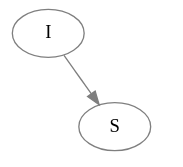

In the Bayesian Network above, the node $I$ represents the probability distribution $P(I)$ and node $S$ represents $P(S \mid I)$. The full joint distribution reprenseted by the Bayesian Network is $P(I, S)$ and can be calculated using the chain rule.

$$
P(I,S) = P(I) \cdot P(S \mid I)
$$

We can define a marginal probability distribution $P(I)$ to express our believe that $30\%$ of all students have a high IQ. DataFrames from the `pandas` package can be used to create the table.

In [ ]:
 I = pd.DataFrame(
    [
        ['high', 0.3],
        ['normal', 0.7]
    ],
    columns=['I', 'p']
)
I

Let's also define a conditinal distribution for $P(S \mid I)$.

In [ ]:
S_given_I = pd.DataFrame(
    [
        ['high', 'high', 0.8],
        ['high', 'low', 0.2],
        ['normal', 'high', 0.05],
        ['normal', 'low', 0.95]
    ],
    columns=['I', 'S', 'p']
)
S_given_I

For example, given the table, a student with a $normal$ IQ only has a $5\%$ chance to have a $high$ SAT score.

With `networkx`, we can associate the given probability tables with their corresponding graph nodes. We use a node attribute named `df` to store the DataFrame reference.

In [ ]:
g.nodes['I']['df'] = I
g.nodes['S']['df'] = S_given_I

Individual values of a node probability table can be accessed as follows.

In [ ]:
def P(nx_graph, node_name, query):
    node = nx_graph.nodes[node_name]
    df = node['df']
    response = df.query(query)
    assert response.shape[0] == 1
    return response['p'].values[0]

In [ ]:
P(g, 'S', 'I == "normal" & S == "high"')

We can now calucalate the joint distribution $P(I, S)$ represented by the Bayesian Network.

$$
P(I, S) = P(I) \cdot P(S \mid I)
$$

In [ ]:
I_S = pd.DataFrame(
    [
        ['high', 'high', P(g, 'I', 'I == "high"') * P(g, 'S', 'I == "high" & S == "high"')],
        ['high', 'low', P(g, 'I', 'I == "high"') * P(g, 'S', 'I == "high" & S == "low"')],
        ['normal', 'high', P(g, 'I', 'I == "normal"') * P(g, 'S', 'I == "normal" & S == "high"')],
        ['normal', 'low', P(g, 'I', 'I == "normal"') * P(g, 'S', 'I == "normal" & S == "low"')]
    ],
    columns=['I', 'S', 'p']
)
I_S

In [ ]:
# verify that probabilities sum to 1.0
assert_almost_equal(I_S['p'].sum(), 1.0)

### Example: Common Cause

Besides $I$ and $S$, a third variable $G$ is introduced to model. $G$ can represent the probabilities of three different grades $good$, $mediocre$, and $bad$.

$$
Val(G) = \{good, mediocre, bad\}
$$

The joint distribution of the model is $P(I, S, G)$.

We could apply the chain rule as follows.

$$
\begin{align}
P(I, S, G) & = P(I) \cdot P(S \mid I) \cdot P(G \mid I, S) \\
           & = P(I) \cdot P(S \mid I) \cdot P(G \mid I) \cdot P(G \mid S)
\end{align}
$$

We can extend the existing Bayesian Networks to include the additional node and edges.

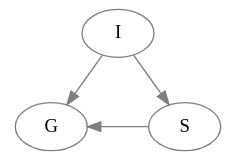

In [ ]:
g.add_node('G', pos=(50, -70))
g.add_edge('I', 'G')
g.add_edge('S', 'G')

For our given problem domain, we can assume that the SAT score does not influence the grade of a person. They might be correlated in a way that a person with a $good$ grade is more likely to score $high$ in the SAT test, but this correlation does only stem from a **common cause**, the intelligence.

We can therefore assume independence of $S$ and $G$ given $I$.

$$
S \perp G \mid I
$$

Therefore the chain rule for $P(I,S,G)$ becomes less complex.

$$
P(I,S,G) = P(I) \cdot P(S \mid I) \cdot P(G \mid I)
$$

The Bayesian Network does not include the edge from $S$ to $G$ anymore.

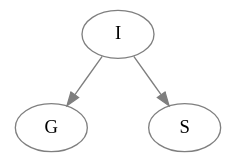

In [ ]:
g.remove_edge('S', 'G')

We can define a probability table for $P(G \mid I)$ and assign the tables to the Bayesian Network nodes.

In [ ]:
G_given_I = pd.DataFrame(
    [
        ['high', 'good', 0.74],
        ['high', 'mediocre', 0.17],
        ['high', 'bad', 0.09],
        ['normal', 'good', 0.2],
        ['normal', 'mediocre', 0.34],
        ['normal', 'bad', 0.46]
    ],
    columns=['I', 'G', 'p']
)
G_given_I

In [ ]:
g.nodes['G']['df'] = G_given_I

Again, it is possible to calculate the joint distribution $P(I, S, G)$ from the given Bayesian Network.

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    for v_s in ['high', 'low']:
        for v_g in ['good', 'mediocre', 'bad']:
            rows.append([
                v_i, v_s, v_g,
                P(g, 'I', f'I == "{v_i}"') * P(g, 'S', f'I == "{v_i}" & S == "{v_s}"') * P(g, 'G', f'I == "{v_i}" & G == "{v_g}"')
            ])
            
I_S_G = pd.DataFrame(
    rows,
    columns=['I', 'S', 'G', 'p']
)
I_S_G

In [ ]:
# verify that probabilities sum to 1.0
assert_almost_equal(I_S_G['p'].sum(), 1.0)

### Example: Indirect Causal Effect

The variable $L$ describes the probability that a recommendation letter is issued for the student.

$$
Val(L) = \{issued, denied\}
$$

The probability of a letter being issued, directly depends on the grade of a student and indirectly depends on the intelligence.

$$
P(I, G, L, S) = P(I) \cdot P(G \mid I) \cdot  P(L \mid G) \cdot P(S \mid I)
$$

As can be seen in the formula for $P(I, G, L, S)$, we have created an **indirect causal effect** of $L$ depending on $G$ and $G$ depending on $I$. The graphical representation is shown below. The path for $I \rightarrow G \rightarrow L$ is highlighted in green.

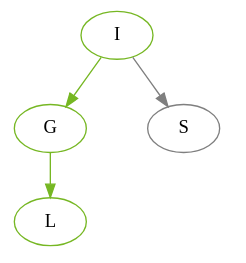

In [ ]:
g.add_node('L', pos=(50, -140))
g.add_edge('G', 'L')
highlight_path(g, ['I', 'G', 'L'], reset=True)

In [ ]:
L_given_G = pd.DataFrame(
    [
        ['good', 'issued', 0.9],
        ['good', 'denied', 0.1],
        ['mediocre', 'issued', 0.6],
        ['mediocre', 'denied', 0.4],
        ['bad', 'issued', 0.01],
        ['bad', 'denied', 0.99]
    ],
    columns=['G', 'L', 'p']
)
L_given_G

In [ ]:
g.nodes['L']['df'] = L_given_G

### Example: Common Effect

The variable $D$ describes the probability, that it was difficult to get a certain grade.

$$
Val(D) = \{hard, easy\}
$$

The probability of getting a $good$, $mediocre$ or $bad$ grade, now depends on both intelligence and difficulty.

$$
\begin{align}
P(D, I, G, L, S) &= P(I) \cdot P(D) \cdot P(G \mid I, D) \cdot P(S \mid I) \cdot P(L \mid G) \\
                 &= P(I) \cdot P(D) \cdot P(G \mid I) \cdot P(G \mid D) \cdot P(S \mid I) \cdot P(L \mid G)
\end{align}
$$

As can be seen in the formula for $P(I, G, D)$, we have created a **common effect** of $G$ depending on $I$ and $D$. The graphical representation is shown below. The path for $D \rightarrow G \leftarrow I$ is highlighted in green.

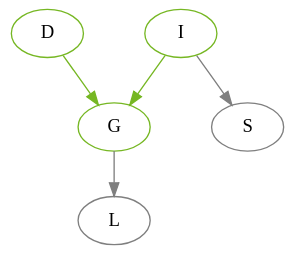

In [ ]:
g.add_node('D', pos=(0, 0))
g.add_edge('D', 'G')
highlight_path(g, ['I', 'G', 'D'], reset=True)

In [ ]:
D = pd.DataFrame(
    [
        ['hard', 0.4],
        ['easy', 0.6]
    ],
    columns=['D', 'p']
)

In [ ]:
g.nodes['D']['df'] = D

Due to the given changes, an update of the probability distribution assigned with node $G$ is required.

In [ ]:
G_given_I_D = pd.DataFrame(
    [
        ['high', 'hard', 'good', 0.5],
        ['high', 'hard', 'mediocre', 0.3],
        ['high', 'hard', 'bad', 0.2],
        ['high', 'easy', 'good', 0.9],
        ['high', 'easy', 'mediocre', 0.08],
        ['high', 'easy', 'bad', 0.02],
        ['normal', 'hard', 'good', 0.05],
        ['normal', 'hard', 'mediocre', 0.25],
        ['normal', 'hard', 'bad', 0.7],
        ['normal', 'easy', 'good', 0.3],
        ['normal', 'easy', 'mediocre', 0.4],
        ['normal', 'easy', 'bad', 0.3]
    ],
    columns=['I', 'D', 'G', 'p']
)
G_given_I_D

In [ ]:
g.nodes['G']['df'] = G_given_I_D

## Theory

As has been shown with the student example, every node in the graph depends on its predecessors. The full joint distribution of an arbitrary Bayesian Network is defined as follows.

$$
P(X_1, ..., X_n) = \prod_{i=1}^n P(X_i \mid predecessors(X_i))
$$

### Observed Variables

In the student example, we are using a predetermined probability distribution over multiple random random variables. In a real world scenario, we would need to determine these values on our own. For example if we have all the data (intelligence, grade, etc.) of a population of 1000 students, we can use this data to calculate marginal and conditional probability distributions to construct a Bayesian Network.

Let's now think of another student, who was not present in the training data. If we want to know, how likely it is that this other student has a $high$ intelligence, we can calculate the value from our existing Bayesian Network. If we don't know anything about the student, all random variables in the Bayesian Network are **hidden** (unobserved), such that all possible outcomes have to be taken into account in the calculation.

Now consider, that we can collect **evidendial** data about this mysterious student, like the grade and SAT score. In this case the random variables $G$ and $S$ become **observed** and instead of taking all possibilities into account, we use a fixed value (e.g. $G=mediocre$ and $S=high$) for the observed variables.

As an example, consider the variables $I$ (intelligence) and $S$ (SAT score). We might not be able to measure the intelligence of a student with a sensor, which means that we cannot observe it. But in the case that we observe a students SAT score, we can infer if the student is likely to be intelligent or not. The observed evidence will give us a more accurate probability of the student having a $high$ intelligence.

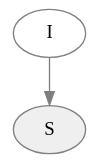

In [ ]:
tmp = nx.DiGraph()
tmp.add_node('I')
tmp.add_node('S', observed=True)
tmp.add_edge('I', 'S')

As shown above, observed variables are depicted as nodes filled with a background color.

A variable's property of being observed or not influences the indepence of other variables in the Bayesian Network and therefore changes the way certain probability values are calculated. The examples in the following sections provide detailed information about different scenarios, where a single random variable in a small Bayesian Network is observed. But in general, we can collect as much evidence as we want and the same rules would still apply. It is even possible to not collect any evidence at all or to observe every single random variable in the Bayesian Network.

### Trails

A trail is a path between two nodes, which might span across other nodes connected by edges. The direction of edges does not matter for a trail to be existent or not.

Consider the trail $S \leftarrow I \rightarrow G \rightarrow L$ in the graph of the student example graph. The direction of edges is not consistent, as shown below.

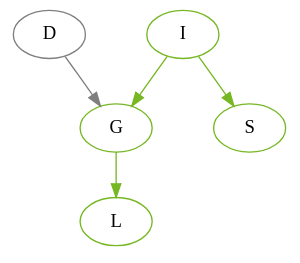

In [ ]:
highlight_path(g, ['S', 'I', 'G', 'L'], reset=True)

A trail between two variables (e.g. $L$ and $S$) may either be **active** or **blocked**. If a trail is active, both variables are dependent. They are independent if a trail is blocked.

The property of a trail being active or blocked depends on certain variables in the Bayesian Network being **observed** or not.

In order to determine if a trail of arbitrary length is active or not, we need an algorithm called **D-Separation**. This algorithm will be discussed in the next notebook [Exercise: D-Separation](exercise-d-separation.ipynb). The foundation of the D-Separation algorithm however, are four basic cases called **indirect causal effect**, **indirect evidential effect**, **common cause** and **common effect**. These basic cases can be explained with **triples** of nodes, as shown in the sections below.

## Inference

### Inference: Indirect Causal Effect

Consider the trail $I \rightarrow G \rightarrow L$ as shown in the Bayesian Network below.

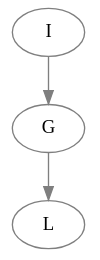

In [ ]:
tmp = nx.DiGraph()
tmp.add_node('I', df=I)
tmp.add_node('G', df=G_given_I)
tmp.add_node('L', df=L_given_G)
tmp.add_edge('I', 'G')
tmp.add_edge('G', 'L')

To calculate $P(L)$, it is required to include variables $I$ and $G$ in the calculation, because $I$ indirectly effects $L$ via $G$. First we can calculate the joint distribution $P(I, G, L)$ and then sum over the hidden variables $I$ and $G$.

$$
\begin{align}
P(L) &= \sum_{I}\sum_{G} P(I) \cdot P(G | I) \cdot P(L | G) \\
     &= \sum_{I}\sum_{G} P(I, G, L)
\end{align}
$$

In a more verbose notation this can also be understood as

$$
P(L) = \sum_{i \in Val(I)} \sum_{g \in Val(G)} P(i, g, L).
$$

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    for v_g in ['good', 'mediocre', 'bad']:
        for v_l in ['issued', 'denied']:
            rows.append([
                v_i, v_g, v_l,
                P(tmp, 'I', f'I == "{v_i}"') * P(tmp, 'G', f'I == "{v_i}" & G == "{v_g}"') * P(tmp, 'L', f'G == "{v_g}" & L == "{v_l}"')
            ])
            
I_G_L = pd.DataFrame(
    rows,
    columns=['I', 'G', 'L', 'p']
)
I_G_L

In [ ]:
L = pd.DataFrame(
    [
        ['issued', I_G_L.query('L == "issued"')['p'].sum()],
        ['denied', I_G_L.query('L == "denied"')['p'].sum()]
    ],
    columns=['L', 'p']
)
L

In a hypothetical scenario, where we just know the intelligence of a student, $I$ becomes an observed variable. 

We can set a fixed value for $I$ and use this evidence to infer $P(L \mid i),\ i \in Val(I)$.

$$
P(L \mid i) = \sum_{G} P(G\mid i) \cdot P(L \mid G),\ i \in Val(I)
$$

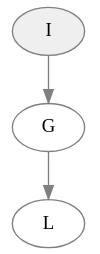

In [ ]:
tmp.nodes['I']['observed'] = True

Let's assume we observe $I = high$.

In [ ]:
rows = []

for v_l in ['issued', 'denied']:
    for v_g in ['good', 'mediocre', 'bad']:
        # L (v_l) and G (v_g) are unobserved variables, while I == high is fixed
        rows.append([
            v_l, v_g,
            P(tmp, 'G', f'I == "high" & G == "{v_g}"') * P(tmp, 'L', f'G == "{v_g}" & L == "{v_l}"')
        ])
            
L_G_I_high = pd.DataFrame(
    rows,
    columns=['L', 'G', 'p']
)
L_G_I_high

In [ ]:
L_I_high = pd.DataFrame(
    [
        ['issued', L_G_I_high.query('L == "issued"')['p'].sum()],
        ['denied', L_G_I_high.query('L == "denied"')['p'].sum()]
    ],
    columns=['L', 'p']
)
L_I_high

Let's now assume similar scenario, but this time only the second variable $G$ in trail $I \rightarrow G \rightarrow L$ is obeserved, as shown in the Bayesian Network below.

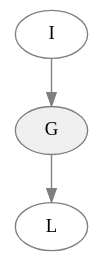

In [ ]:
tmp.nodes['I']['observed'] = False
tmp.nodes['G']['observed'] = True

If we observe, that the grade $G$ of a student is $good$, we can take this evidence to answer a query for $P(L \mid g),\ g \in Val(G)$, without using $I$ in the calculation. In this case $L$ is independent of $I$ given $G$. The trail between $I$ and $L$ is blocked by the observation of $G$.

$$
L \perp I \mid g,\ g \in Val(G)
$$

The intelligence $I$ does not provide any additional information in this situation. $P(L \mid G=good)$ is just a table lookup.

In [ ]:
tmp.nodes['L']['df'].query('G == "good"')

### Inference: Indirect Evidential Effect

Consider trail $L \leftarrow G \leftarrow I$, which is the equivalent to $I \rightarrow G \rightarrow L$ used in the last example, but this time, we would like to answer a query about $I$. Let's assume $L$ is observed and we want to calculate $P(I \mid l),\ l \in Val(L)$.

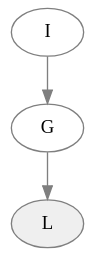

In [ ]:
tmp.nodes['G']['observed'] = False
tmp.nodes['L']['observed'] = True

$$
P(I \mid l) = \frac{1}{Z} \cdot \sum_{G} P(I) \cdot P(G \mid I) \cdot P(l \mid G),\ l \in Val(L)
$$

Normalization by a factor $\frac{1}{Z}$ is required for probabilities in table $P(I \mid l)$ to not sum to $1$.

To gain some intuition about the normalization factor, we can look at the joint distribution of our small Bayesian Network.

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    for v_g in ['good', 'mediocre', 'bad']:
        for v_l in ['issued', 'denied']:
            rows.append([
                v_i, v_g, v_l,
                P(tmp, 'I', f'I == "{v_i}"') * P(tmp, 'G', f'I == "{v_i}" & G == "{v_g}"') * P(tmp, 'L', f'G == "{v_g}" & L == "{v_l}"')
            ])
            
I_G_L = pd.DataFrame(
    rows,
    columns=['I', 'G', 'L', 'p']
)
I_G_L

In [ ]:
# probabilities in a full joint distribution sum to 1
assert_almost_equal(I_G_L['p'].sum(), 1.0)

If $L$ is observed to be $issued$, we only account for a subset of the joint distribution where $L = issued$.

In [ ]:
I_G_L_issued = I_G_L.query('L == "issued"')
I_G_L_issued

In [ ]:
# the sum of the probabilities is not equals 1.0
I_G_L_issued['p'].sum()

To calculate $P(I \mid L=issued)$ we sum over $G$.

In [ ]:
I_L_issued = pd.DataFrame(
    [
        ['high', I_G_L_issued.query('I == "high"')['p'].sum()],
        ['normal', I_G_L_issued.query('I == "normal"')['p'].sum()]
    ],
    columns=['I', 'p']
)

I_L_issued

Since the last table `I_G_L_issued` did not sum to one, also the new table `I_L_issued` does not sum to one.

In [ ]:
I_L_issued['p'].sum()

To gain back proper probabilities, we can normalize the resulting values by their sum $Z$.

In [ ]:
# normalization
Z = I_L_issued['p'].sum()
I_L_issued['p'] = I_L_issued['p'] / Z
I_L_issued

Now, if $G$ is observed instead of $L$, the path between $I$ and $L$ is blocked.

$$
I \perp L \mid g,\ g \in Val(G)
$$

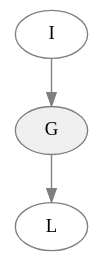

In [ ]:
tmp.nodes['G']['observed'] = True
tmp.nodes['L']['observed'] = False

$$
P(I \mid g) = \frac{1}{Z} \cdot P(I) \cdot P(g \mid I),\ g \in Val(G)
$$

For example, we can calculate $P(I \mid G = good)$.

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    rows.append([
        v_i,
        P(tmp, 'I', f'I == "{v_i}"') * P(tmp, 'G', f'I == "{v_i}" & G == "good"')
    ])
            
I_G_good = pd.DataFrame(
    rows,
    columns=['I', 'p']
)

# normalization
Z = I_G_good['p'].sum()
I_G_good['p'] = I_G_good['p'] / Z

I_G_good

### Inference: Common Cause

In the student example graph a common cause was given by the V-shaped structure $G \leftarrow I \rightarrow S$ as shown below. In this example $G$ and $S$ both depend on $I$.

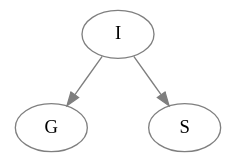

In [ ]:
tmp = nx.DiGraph()
tmp.add_node('I', df=I, pos=(100, 0))
tmp.add_node('S', df=S_given_I, pos=(150, -70))
tmp.add_node('G', df=G_given_I, pos=(50, -70))
tmp.add_edge('I', 'S')
tmp.add_edge('I', 'G')

If $G$ is observed we can use this evidence to calculate $P(S \mid g),\ g \in Val(G)$. We sum over $I$ to remove the hidden variable.

$$
P(S \mid g) = \frac{1}{Z} \cdot \sum_{I} P(I) \cdot P(g \mid I) \cdot P(S \mid I),\ g \in Val(G)
$$

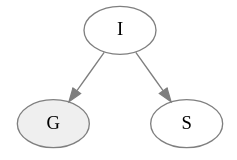

In [ ]:
tmp.nodes['G']['observed'] = True

For $P(S \mid G = good)$ the following code shows the exact calculation.

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    for v_s in ['high', 'low']:
        rows.append([
            v_i, v_s,
            P(tmp, 'I', f'I == "{v_i}"') * P(tmp, 'G', f'I == "{v_i}" & G == "good"') * P(tmp, 'S', f'I == "{v_i}" & S == "{v_s}"')
        ])
            
G_good_I_S = pd.DataFrame(
    rows,
    columns=['I', 'S', 'p']
)

G_good_I_S

In [ ]:
S_G_good = pd.DataFrame(
    [
        ['high', G_good_I_S.query('S == "high"')['p'].sum()],
        ['low', G_good_I_S.query('S == "low"')['p'].sum()]
    ],
    columns=['S', 'p']
)

# normalization
Z = S_G_good['p'].sum()
S_G_good['p'] = S_G_good['p'] / Z

S_G_good

In the case that $I$ is observed, the path between $G$ and $S$ is blocked.

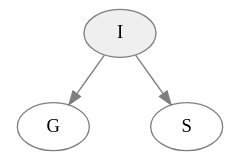

In [ ]:
tmp.nodes['G']['observed'] = False
tmp.nodes['I']['observed'] = True

$P(S \mid I = high)$ is just a table lookup.

In [ ]:
tmp.nodes['S']['df'].query('I == "high"')

### Inference: Common Effect

In the student example graph the trail $D \rightarrow G \leftarrow I$ describes a common effect.

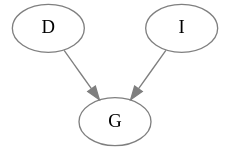

In [ ]:
tmp = nx.DiGraph()
tmp.add_node('D', df=D, pos=(0, 0))
tmp.add_node('I', df=I, pos=(100, 0))
tmp.add_node('G', df=G_given_I_D, pos=(50, -70))
tmp.add_edge('D', 'G')
tmp.add_edge('I', 'G')

In this case the trail from $D$ to $I$ is blocked if $G$ is unobserved (hidden). This means, that observing $D$ does not give us any more information about $I$, as long as $G$ is unobserved.

On the other hand, if $G$ is observed, we have to include $D$ in the calculation of $P(I \mid g),\ g \in Val(G)$

$$
P(I \mid g) = \frac{1}{Z} \cdot \sum_{D} P(I) \cdot P(D) \cdot P(g \mid I, D)
$$

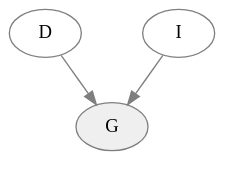

In [ ]:
tmp.nodes['G']['observed'] = True

The calculation of $P(I \mid G = good)$ is shown in the calculation below.

In [ ]:
rows = []

for v_i in ['high', 'normal']:
    for v_d in ['hard', 'easy']:
        rows.append([
            v_i, v_d,
            P(tmp, 'I', f'I == "{v_i}"') * P(tmp, 'D', f'D == "{v_d}"') * P(tmp, 'G', f'G == "good" & I == "{v_i}" & D == "{v_d}"')
        ])
            
I_D_G_good = pd.DataFrame(
    rows,
    columns=['I', 'D', 'p']
)

I_D_G_good

In [ ]:
I_G_good = pd.DataFrame(
    [
        ['high', I_D_G_good.query('I == "high"')['p'].sum()],
        ['normal', I_D_G_good.query('I == "normal"')['p'].sum()]
    ],
    columns=['I', 'p']
)

# normalization
Z = I_G_good['p'].sum()
I_G_good['p'] = I_G_good['p'] / Z

I_G_good

The trail $D \rightarrow G \leftarrow I$ is also **active**, if some other node depending on $G$ is observed, as shown in the graph below.

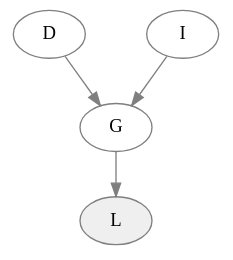

In [ ]:
tmp.nodes['G']['observed'] = False
tmp.add_node('L', df=L_given_G, observed=True, pos=(50,  -140))
tmp.add_edge('G', 'L')

## Summary and Outlook

This was an introduction to the basic mechanics of a Bayesian Network. The student example has been used to demonstrate the way probability distributions are encoded in such a network and how to run inference queries, when observed variables are involved.

We recommend learning about sampling in Bayesian Networks and D-Separation (see notebook [Exercise: D-Separation](exercise-d-separation.ipynb)), as well as special forms like Naive Bayes, Markov Models and Hidden Markov Models. Hidden Markov Models are especially useful for sequential applications like [Named Entity Recognition](../../../text-information-extraction.md) tagging of sentences in the Natural Language Processing domain.

## Literature

<table>
    <tr>
        <td>
            <a name="KOL09"></a>[KOL09]
        </td>
        <td>
            D. Koller and N. Friedman, “Probabilistic Graphical Models - Principles and Techniques”, Chapter 3, Massachusetts Institute of Technology, USA, 2009.
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Machine Learning Fundamentals - Probability Theory - Bayesian Networks by Example <br/>
by [Christoph Jansen (deep.TEACHING - HTW Berlin)](https://www.htw-berlin.de/hochschule/personen/person/?eid=9225)<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 _Author_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.